# 자세 분석 프로젝트

이 노트북은 **가속도 센서 데이터를 활용하여 사람의 자세를 분류**하는 프로젝트입니다.  
전체 과정은 아래와 같은 단계로 구성되어 있습니다:

1. 데이터 로딩
2. 센서 값 시각화 및 특징 추출
3. 머신러닝 모델 학습 및 평가
4. 최종 자세 분류 결과 확인

> 본 프로젝트는 노인 욕창 예방을 위한 자세 분석 시스템 개발의 일환으로 진행되었습니다.


### 라이브러리 로드

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier

### 데이터 불러오기
- 데이터 설명 : final_data에 들어있는 A, B, C, D, E 데이터는 각각 A_back, front, left, right, other를 합친 데이터
- A_back : 1분 동안 뒤로 누운 자세
- A_front : 1분 동안 앞으로 누운 자세
- A_left : 1분 동안 왼쪽으로 누운 자세
- A_right : 1분 동안 오른쪽으로 누운 자세
- A_others : 1분 동안 위에 있는 자세가 아닌 의자에 앉아 있는 자세

In [6]:
data = pd.read_csv('data/final_data/A.csv', index_col=False)

### 데이터 시각화
- 알고리즘을 짜기위해 시간과 가속도 x, y, z의 변화를 보기 위해 그래프를 만듦

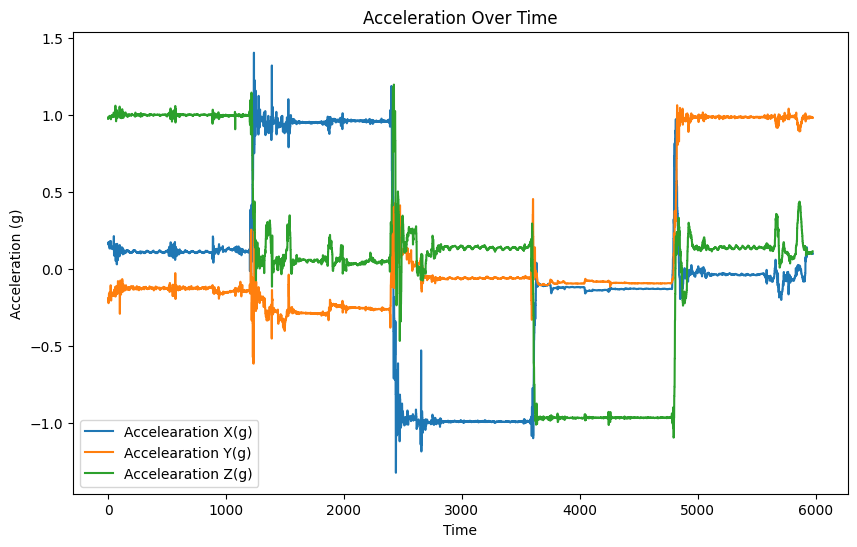

In [5]:
time = data['Time']
accel_x = data['Acceleration X(g)']
accel_y = data['Acceleration Y(g)']
accel_z = data['Acceleration Z(g)']

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(accel_x, label='Accelearation X(g)')
plt.plot(accel_y, label='Accelearation Y(g)')
plt.plot(accel_z, label='Accelearation Z(g)')
plt.xlabel('Time')
plt.ylabel('Acceleration (g)')
plt.title('Acceleration Over Time')
plt.legend()
plt.show()

### 데이터 전처리
- 실시간으로 데이터를 처리하는 어플이었지만 알고리즘을 짜기 위해 3초 단위로 평균값 계산
- 위처럼 3초 단위로 평균값을 내린 이유는 환자와 노인의 욕창을 예방하기 위한 자세분석과 알고리즘이었기 때문에 큰 움직임이 없을것으로 생각
- 따라서 3초 단위로 평균값을 내려도 오차가 크지 않을 것으로 예상

In [ ]:
# 시간 문자열을 초 단위로 변환하는 함수
def time_to_seconds(time_str):
    time_parts = time_str.split(':')
    seconds = int(time_parts[0]) * 3600 + int(time_parts[1]) * 60 + float(time_parts[2])
    return seconds

# 모든 시간 데이터를 초 단위로 변환
data['Time_Seconds'] = data['Time'].apply(time_to_seconds)

# 가속도 데이터 숫자형으로 변환
data['Acceleration X(g)'] = pd.to_numeric(data['Acceleration X(g)'], errors='coerce')
data['Acceleration Y(g)'] = pd.to_numeric(data['Acceleration Y(g)'], errors='coerce')
data['Acceleration Z(g)'] = pd.to_numeric(data['Acceleration Z(g)'], errors='coerce')

# 3초 간격으로 데이터 평균값 계산
grouped_data = data.groupby(data['Time_Seconds'] // 3).mean(numeric_only=True).reset_index(drop=True)

### 알고리즘
- 초기 알고리즘을 만들 때 임계값을 부여해서 비교하려고 생각 -> 사람마다 무게도 눕는 자세도 조금씩은 달라서 임계값 설정하기 어려움
- 그 이후 가속도 x, y, z 의 대소비교를 이용해서 비교 -> A, B, C, D, E의 데이터를 시각화한 결과 x, y, z의 대소비교가 다를 때가 존재
- 최종적으로 절대값을 이용한 대소비교를 이용해서 비교 -> 절대값과 대소비교를 이용함으로써 5명의 데이터 모두 적용했을 때 동일하게 성능 결과가 좋았음

In [ ]:
# 데이터에서 필요한 열 추출
acc_z = grouped_data['Acceleration Z(g)']
acc_x = grouped_data['Acceleration X(g)']
acc_y = grouped_data['Acceleration Y(g)']

# 데이터를 특성과 타겟으로 분할
X = grouped_data[['Acceleration Z(g)', 'Acceleration X(g)', 'Acceleration Y(g)']]

y = []
for az, ax, ay in zip(acc_z, acc_x, acc_y):
    if abs(az) > abs(ax) and abs(az) > abs(ay):  # Suspine
        if az > 0:
            y.append('Suspine')
        elif az < 0:
            y.append('Prone')  #Prone
    elif abs(ax) > abs(az) and abs(ax) > abs(ay):  # Right
        if ax > 0:
            y.append('Right')
        elif ax < 0:
            y.append('Left')  #Left
    else:
        y.append('Unknown') #Unknown

### 인코딩
- 알고리즘을 통해 구분 된 자세들의 클래스 개수를 확인하고 정의 및 인코딩
- 혼동행렬을 표현하기 위해 사용

In [ ]:
# 클래스 개수 확인
class_counts = pd.Series(y).value_counts()
print("Classes found:", class_counts)

# 모든 가능한 클래스 레이블 정의
all_classes = ['Suspine', 'Prone', 'Right', 'Left', 'Unknown']

# 클래스 인코딩
label_encoder = LabelEncoder()
label_encoder.fit(all_classes)  # 모든 가능한 클래스로 fit
y_encoded = label_encoder.transform(y)
class_names = label_encoder.classes_  # 모든 가능한 클래스 이름

#### 결과
- 혼동행렬을 이용
- SGDClassifier 사용 -> 실시간 데이터이기 때문에 검증하는 데이터의 수는 많지 않지만 속도를 위해 속도가 빠른 SCDClassifier 사용, 또한 다중 클래스(suspine, prone, right, left, unknown)에 잘 동작하기 때문에 SGDClassifier 사용
- cross_val_predict(교차검증) 사용 -> 과적합 없이 예측 성능 평가하기 위해 사용
- F1 score로 정확도 계산 -> 단순히 정확도보다 더 공정하고 의미 있는 평가 지표이기 때문에 사용, 클래스 불균형일시 문제에 대응하기 위해 사용
- F1 Score = 2 * (precision * recall) / (precision + recall)
- 완성된 혼동행렬 시각화

In [ ]:
# 클래스 개수 확인
class_counts = pd.Series(y).value_counts()
print("Classes found:", class_counts)

# 모든 가능한 클래스 레이블 정의
all_classes = ['Suspine', 'Prone', 'Right', 'Left', 'Unknown']

# 클래스 인코딩
label_encoder = LabelEncoder()
label_encoder.fit(all_classes)  # 모든 가능한 클래스로 fit
y_encoded = label_encoder.transform(y)
class_names = label_encoder.classes_  # 모든 가능한 클래스 이름

# 클래스 수 확인
if len(np.unique(y_encoded)) == 1:
    print("Only one class found. Creating a full confusion matrix with all possible labels.")
    f1 = 100.0
    predicted_states = y_encoded

    # 전체 혼동 행렬 생성 (모든 클래스에 대해)
    conf_matrix = np.zeros((len(all_classes), len(all_classes)), dtype=int)
    actual_class_index = np.where(class_names == y[0])[0][0]
    conf_matrix[actual_class_index, actual_class_index] = len(y_encoded)
else:
    # SGDClassifier 모델 생성 및 예측
    model = SGDClassifier(random_state=3224)
    predicted_states = cross_val_predict(model, X, y_encoded, cv=4)

    # 혼동 행렬 생성
    conf_matrix = confusion_matrix(y_encoded, predicted_states, labels=range(len(all_classes)))

    # F1 스코어 계산 (zero_division=1 설정)
    f1 = f1_score(y_encoded, predicted_states, average='weighted', zero_division=1) * 100

# 혼동 행렬 시각화
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)

plt.title('Confusion Matrix')
plt.show()

print(f"F1 Score: {f1:.2f}")

### 논문에 사용할 그래프 만들기 위해 시각화 업그레이드

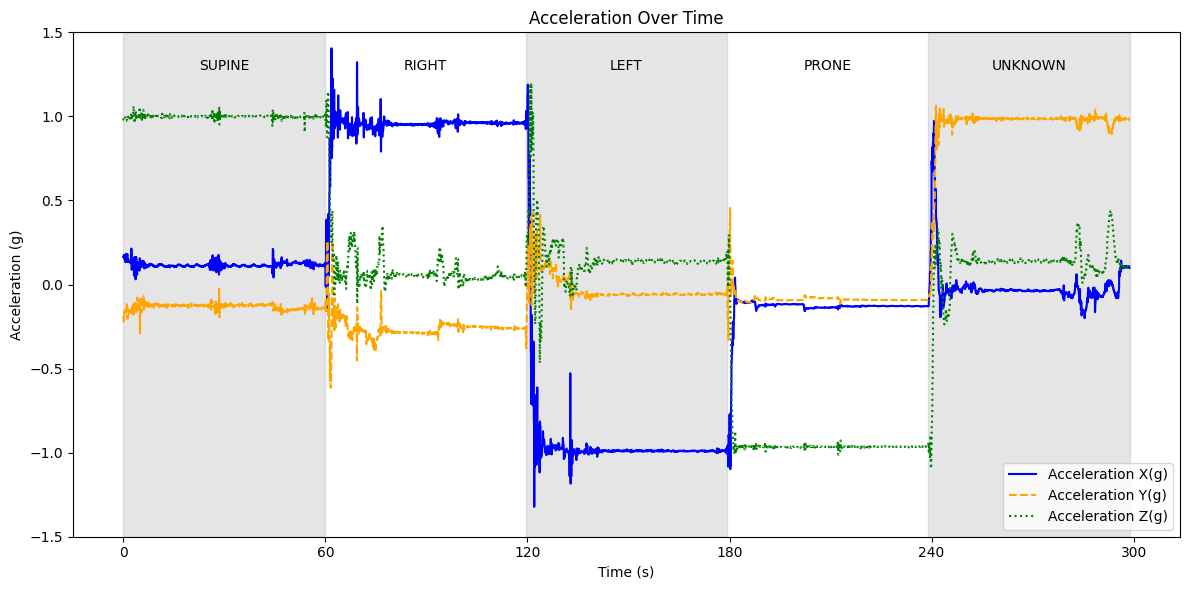

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
time = data['Time']
accel_x = data['Acceleration X(g)']
accel_y = data['Acceleration Y(g)']
accel_z = data['Acceleration Z(g)']

# 밀리초를 초로 변환하기 위한 인덱스 생성
time_in_seconds = np.arange(len(time)) / 20  # 밀리초를 초로 변환

# 그래프 설정
fig, ax = plt.subplots(figsize=(12, 6))

# 가속도 데이터 플로팅
ax.plot(time_in_seconds, accel_x, label='Acceleration X(g)', linestyle='-', color='blue')
ax.plot(time_in_seconds, accel_y, label='Acceleration Y(g)', linestyle='--', color='orange')
ax.plot(time_in_seconds, accel_z, label='Acceleration Z(g)', linestyle=':', color='green')

# 자세 구간 정의 (시간을 초 단위로 변환)
total_seconds = len(time) / 20  # 전체 시간을 초로 변환
positions = [
    (0, total_seconds/5, 'SUPINE'),
    (total_seconds/5, 2*total_seconds/5, 'RIGHT'),
    (2*total_seconds/5, 3*total_seconds/5, 'LEFT'),
    (3*total_seconds/5, 4*total_seconds/5, 'PRONE'),
    (4*total_seconds/5, total_seconds, 'UNKNOWN')
]

# 자세 구간 배경 및 레이블 추가
for i, (start, end, label) in enumerate(positions):
    if i % 2 == 0:  # 짝수 인덱스에만 회색 배경 추가
        ax.axvspan(start, end, color='gray', alpha=0.2)

    # 구간 중앙에 레이블 추가
    ax.text((start + end)/2, 1.3, label,
            horizontalalignment='center',
            verticalalignment='center',
            color='black',
            fontsize=10)

# 축 설정
ax.set_xlabel('Time (s)')  # 단위를 초로 변경
ax.set_ylabel('Acceleration (g)')
ax.set_title('Acceleration Over Time')

# y축 범위 설정
ax.set_ylim(-1.5, 1.5)

# x축 눈금 설정 (1분 단위)
tick_interval = 60  # 1분 간격
max_time = total_seconds
tick_positions = np.arange(0, max_time + tick_interval, tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels([str(int(x)) for x in tick_positions])

# 범례 위치를 오른쪽 아래로
ax.legend(loc='lower right')

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()
